# Compare clustering using finite mixture vs DP mixture of Gaussians

In [1]:
try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

from probml_utils.dp_mixgauss_utils import NormalInverseWishart, gmm_gibbs, dp_mixgauss_gibbs

import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.linalg import sqrtm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Silence WARNING:root:The use of `check_types` is deprecated and does not have any effect.
# https://github.com/tensorflow/probability/issues/1523
import logging

logger = logging.getLogger()


class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())

In [3]:
dim = 2
concentration = 1.0
n_data = 300
n_gibbs_samples = 1000
burn_in = 200
mean_precisions = [0.01, 0.5]
n_clusters_true = 4
n_clusters_input = [2, 4, 6]

In [4]:
data_set = []
samples_set = []
for m_precision in mean_precisions:
    print(f"Example with the precision parameter of the NIW prior being {m_precision}.")
    print("Generating data ...")
    samples = []
    # Generating the true data from a finite mixture model
    key = random.PRNGKey(0)
    key, *subkeys = random.split(key, 4)
    niw_params = dict(loc=jnp.zeros(dim), mean_precision=m_precision, df=dim + 5, scale=jnp.eye(dim))
    niw = NormalInverseWishart(**niw_params)
    cluster_weights = random.dirichlet(subkeys[0], 5.0 * jnp.ones(n_clusters_true))
    # cluster assignment of each datum
    cluster_indices = random.categorical(subkeys[1], jnp.log(cluster_weights), shape=(n_data,))
    cluster_params = niw.sample(seed=subkeys[2], sample_shape=(n_clusters_true,))
    cluster_covs = cluster_params["Sigma"]
    cluster_means = cluster_params["mu"]
    # data
    mean_per_datum = cluster_means[cluster_indices]
    cov_per_datum = cluster_covs[cluster_indices]
    key, *subkeys = random.split(key, n_data + 1)
    data = vmap(random.multivariate_normal, in_axes=(0, 0, 0))(jnp.array(subkeys), mean_per_datum, cov_per_datum)
    data_set.append(data)

    print("Begin clustering via...")
    # Clustering via finite mixture model
    for n_clusters in n_clusters_input:
        print(f"finite mixture model with K = {n_clusters};")
        gmm_samples = gmm_gibbs(key, burn_in + n_gibbs_samples, data, concentration, n_clusters, niw_params)
        gmm_samples = gmm_samples[burn_in:]
        samples.append(gmm_samples)

    # Clustering via DP mixture model
    print(f"DP mixture model.")
    dp_samples = dp_mixgauss_gibbs(key, burn_in + n_gibbs_samples, data, concentration, niw_params)
    dp_samples = dp_samples[burn_in:]
    samples.append(dp_samples)

    samples_set.append(samples)
    print("Finish clustering.")

Example with the precision parameter of the NIW prior being 0.01.
Generating data ...
Begin clustering via...
finite mixture model with K = 2;
finite mixture model with K = 4;
finite mixture model with K = 6;
DP mixture model.
Finish clustering.
Example with the precision parameter of the NIW prior being 0.5.
Generating data ...
Begin clustering via...
finite mixture model with K = 2;
finite mixture model with K = 4;
finite mixture model with K = 6;
DP mixture model.
Finish clustering.


(DeviceArray([0, 1], dtype=int32), DeviceArray([203,  97], dtype=int32))


/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(DeviceArray([0, 1, 2], dtype=int32), DeviceArray([ 23,  72, 205], dtype=int32))


/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(DeviceArray([1, 2, 4, 5], dtype=int32), DeviceArray([ 21,  36, 171,  72], dtype=int32))


/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(DeviceArray([0, 3, 4, 5], dtype=int32), DeviceArray([ 22,  72,  29, 177], dtype=int32))


/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


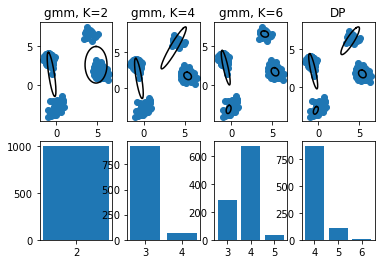

(DeviceArray([0, 1], dtype=int32), DeviceArray([  8, 292], dtype=int32))


/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(DeviceArray([0, 2, 3], dtype=int32), DeviceArray([  1, 237,  62], dtype=int32))


/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(DeviceArray([1, 2, 3, 4, 5], dtype=int32), DeviceArray([250,  31,   3,  12,   4], dtype=int32))


/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(DeviceArray([0, 4, 5], dtype=int32), DeviceArray([  1,  11, 288], dtype=int32))


/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


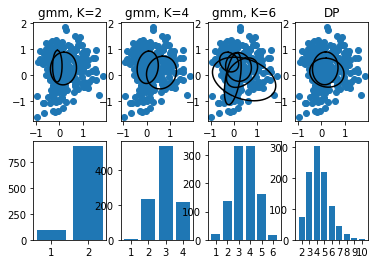

In [5]:
n_examples = 2
for k in range(n_examples):
    data = data_set[k]
    fig_col = 4
    fig_row = 2
    fig, axes = plt.subplots(2, fig_col)
    col_names = ["gmm, K=2", "gmm, K=4", "gmm, K=6", "DP"]
    for i in range(fig_col):
        samples = samples_set[k][i]
        final = samples[-1]
        print(jnp.unique(final, return_counts=True))
        # Plot the final cluster
        ax = axes[0, i]
        ax.set_title(col_names[i])
        ax.scatter(data[:, 0], data[:, 1])
        final_clusters = samples[-1, :]
        for cluster_index in jnp.unique(final_clusters):
            subset = data[final_clusters == cluster_index, :]
            if subset.shape[0] == 1:
                continue
            mu = jnp.atleast_2d(jnp.mean(subset, axis=0)).T
            sig = sqrtm(jnp.cov(subset, rowvar=False))
            bb = jnp.arange(0, 2 * jnp.pi, 0.02)
            circ = mu.dot(jnp.ones((1, len(bb)))) + sig.dot(jnp.vstack([jnp.sin(bb), jnp.cos(bb)]))
            ax.plot(circ[0, :], circ[1, :], linewidth=1.5, color="k")

        # Histogram of the frequences of number of clusters
        # returned by the Gibbs sampler
        ax = axes[1, i]
        n_clusters = jnp.array([len(jnp.unique(s)) for s in samples])
        unique_ns, unique_counts = np.unique(n_clusters, return_counts=True)
        ax.bar(unique_ns.astype(str), unique_counts, width=0.8)

    plt.show()